In [116]:
#Материалы:
#https://www.youtube.com/watch?v=gXBs4_3aKrs&feature=youtu.be
#https://habr.com/ru/company/hh/blog/427477/

In [102]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
#matplotlib.style.use('qqplot')
from datetime import datetime, date
import seaborn as sns; sns.set()
%matplotlib inline

In [103]:
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from sklearn import preprocessing
from sklearn.decomposition import TruncatedSVD 
from sklearn.manifold import TSNE

In [104]:
#Признаки рассчитываются для пары: П+стаж его работы в SkyEng в месяцах.
#Считается, что П работал в месяце A, если у него были успешные уроки в этом месяце.
#Исключаются П без базовой ставки и строки, для которых не удалось вытащить какие-либо данные

#Рассматриваемые признаки:

#1. Пол - бинарный признак (1 - женщина)
#2. Возраст (разбивка) - разбиваем возраста на группы с присвоением номера с приблизительно одинаковым кол-ом П в каждой группе.
#   Возраст расситывается на момент рассматриваемого месяца.
#3. Страна (RU/не RU) - бинарный признак
#4. Город (чтобы значения этого признака можно было сравнивать между собой, каждому региону присвоено общее число П, 
#   входящих в этот регион, и взят от этого числа логарифм, чтобы сгладить разницу между очень крупными и мелкими значениями)
#5. Категория (A, B, C, Critical --> 0,1,2,3) - данные из KPI
#6. Стаж работы П в целом (лет) - общий стаж работы П преподвателем (не только в skyeng)
#7. ОГЭ - П преподает ОГЭ
#8. ЕГЭ - П преподает ЕГЭ
#9. ВПР - П преподает ЕГЭ
#10.Math Low knowledge'
#11.Math_VIP
#12.П младших классов - П занимается с 1-4 классами
#13.П средних классов - П занимается с 1-8 классами
#14.П старших классов - П занимается с 9-11 классами
#15.П готовит к олимпиадам
#16.SLA начала у (Начинает ли П занятия вовремя в месяце) - доля уроков, для которых П завел комнату вовремя (минимум за 1 мин)
#17.SLA подтверждения У в TT (накопительно) - вовремя ли П подтверждает У (в течение 12 часов)
#18.Процент переподбора (накопительно) - доля замен учителя
#19.Открытые часы (1ая неделя месяца)
#20.Часы в прайм тайм (1ая неделя месяца)
#21.Количество уникальных учеников - в месяц
#22.Количество проведённых уроков - в месяц
#23.Дисциплина
#24.Потерянные студенты
#25.Ассессмент_процент
#26.Асcессмент_Общие уроки
#27.Ассессмент_Структура урока
#28.Ассессмент_Работа с учеником



In [123]:
df = pd.read_excel(r'C:\Users\79035\clustering_of_teachers.xlsx', sheet_name = 'final')
df = df[(df['Исключить'] == 'Нет')]

In [126]:
# Обработка отдельных столбцов

# Обработка категорий:
def category(x):
    if x == 'A':
        return 0
    elif x == 'B':
        return 1
    elif x == 'C':
        return 2
    else:
        return 3
    
df['Категория (0,1,2,3)'] = df['Категория'].map(lambda x: category(x))

# Обработка стран:
df['Страна (1-RU)'] = df['Страна'].map(lambda x: 1 if x == 'RU' else 0)

# Обработка возрастов. Разбиваем возраста на группы, с приблизительно одинаковым кол-ом П в каждой группе.
# Кол-во групп можно менять.

n = 3
age_intervals = np.array_split(sorted(df['Возраст П (лет)'].values), n)
def get_age_interval_index(age, intervals):
    for i in range(0, len(intervals)):
        if age in intervals[i]:
            return i + 1
    return -1

df['Возраст (разбивка)'] = df['Возраст П (лет)'].map(lambda x: get_age_interval_index(x, age_intervals))

#Обработка городов. Чтобы значения этого признака можно было сравнивать между собой, каждому региону присвоено общее число П, 
#входящих в этот регион, и взят от этого числа логарифм, чтобы сгладить разницу между крупными и мелкими значениями.

log_city = df[['Город', 'teacher_id']].copy()
log_city.drop_duplicates(inplace = True)
log_city = log_city.groupby(['Город']).count()
log_city['log(кол-во П в городе)'] = np.log(log_city['teacher_id'])
log_city.rename(columns={'old_name_1': 'new_name_1', 'old_name_2': 'new_name_2'}, inplace=True)
df2 = pd.merge(df, log_city[['log(кол-во П в городе)']], on = 'Город')

#for x in df2.columns:
#    print(x)

In [127]:
# Датафреймы с нужными признаками для дальнейшей кластеризации

# Датафрейм с постоянными признаками:
df_const = df2[['teacher_id',
                'Пол (1-Ж)',
                'Возраст (разбивка)',
                'Страна (1-RU)',
                'log(кол-во П в городе)',
                'Категория (0,1,2,3)',
                'Стаж работы П в целом (лет)',
                'ОГЭ',
                'ЕГЭ',
                'ВПР',
                'Math Low knowledge',
                'Math_VIP',
                'П младших классов',
                'П средних классов',
                'П старших классов',
                'П готовит к олимпиадам',
                ]].copy()

df_const = df_const.apply(pd.to_numeric)

#Датафрейм с изменяющимися признаками из месяца в месяц:
df_var = df2[['teacher_id',
            'Месяц',
            'SLA начала у (Начинает ли П занятия вовремя в месяце)',
            'SLA подтверждения У в TT (накопительно)',
            'Процент переподбора (накопительно)',
            'Открытые часы (1ая неделя месяца)',
            'Часы в прайм тайм (1ая неделя месяца)',
            'Количество уникальных учеников',
            'Количество проведённых уроков',
            'Дисциплина',
            'Потерянные студенты',
            'Retention',
            'Ассессмент_процент',
            'Асcессмент_Общие уроки',
            'Ассессмент_Структура урока',
            'Ассессмент_Работа с учеником'
            ]].copy()

df_var = df_var.apply(pd.to_numeric)

In [128]:
# Получаем таблицу со значениями неизменяющихся признаков для каждого учителя:
df_const_mean = df_const.groupby(['teacher_id']).mean()


# Рассчитываем таблицу со средними значениями изменяющихся признаков для каждого учителя.
# Для сглаживания влияния сезонности делим значение признака для П в месяц Х на среднее значение этого признака по всем П
# в месяц Х. Таким образом, если значаение нового признака будем больше 1, то у П значение признака выше среднего в месяц Х. 
# Далее усредняем получившиеся значения нового признака по всем месяцам.

# Группируем по месяцам и считаем средние значения для каждого показателя
b = df_var.drop('teacher_id', axis = 1)
a = b.groupby('Месяц').mean()

# Джойним изначальную таблицу с изменяющимися признаками с получившейся таблицей со средними значениямим по месяцам 
df4 = pd.merge(df_var, a, on = 'Месяц')

# Рассчитываем отношение значения признака для П в месяц Х к среднему значению этого признака по всем П в месяц Х
columns = df_var.columns

# Готовим функкию, которую будем подавать в функцию apply
def div(row):
    if row.values[1] != 0:
        return row.values[0] / row.values[1]
    else:
        return -1

# Рассчет:
for col_name in columns:
    if col_name != 'teacher_id' and col_name != 'Месяц':
        df4[col_name] = df4[[col_name + "_x", col_name + "_y"]].apply(lambda row: div(row), axis = 1)
        df4 = df4.drop(col_name + '_x', axis = 1)
        df4 = df4.drop(col_name + '_y', axis = 1)
        
df4.drop('Месяц', axis = 1, inplace = True)

# Получаем таблицу со средними значениями изменяющихся признаков по учителям:
df_var_mean = df4.groupby('teacher_id').mean()

# Итоговая таблица со средними значениями показателей:
df_for_clust = pd.merge(df_const_mean, df_var_mean, on = 'teacher_id')



In [129]:
df_for_clust.head()

,Пол (1-Ж),Возраст (разбивка),Страна (1-RU),log(кол-во П в городе),"Категория (0,1,2,3)",Стаж работы П в целом (лет),ОГЭ,ЕГЭ,ВПР,Math Low knowledge,...,Часы в прайм тайм (1ая неделя месяца),Количество уникальных учеников,Количество проведённых уроков,Дисциплина,Потерянные студенты,Retention,Ассессмент_процент,Асcессмент_Общие уроки,Ассессмент_Структура урока,Ассессмент_Работа с учеником
teacher_id,,,,,,,,,,,,,,,,,,,,,
2170299,1.0,1.0,1.0,3.367296,1.0,1.727273,1.0,1.0,1.0,1.0,...,1.837865,1.251856,1.511782,0.993692,1.073022,0.963260,1.025398,1.064573,0.977963,1.038298
2365531,0.0,2.0,1.0,1.386294,3.0,1.727273,1.0,1.0,0.0,1.0,...,1.969538,1.010841,1.347507,0.986616,0.824916,0.980447,0.968537,0.988839,0.980364,0.962899
2369769,1.0,2.0,1.0,1.386294,2.0,8.727273,0.0,0.0,0.0,0.0,...,0.687001,0.423821,0.481284,0.860695,0.353535,1.105751,0.968537,0.988839,0.980364,0.962899
2377349,0.0,1.0,1.0,2.197225,1.0,4.727273,1.0,1.0,0.0,1.0,...,1.322201,1.336076,1.114172,0.902495,0.324675,0.976172,0.968537,0.988839,0.980364,0.962899
2550373,1.0,2.0,1.0,2.197225,2.0,5.727273,1.0,1.0,0.0,1.0,...,1.090728,1.357481,1.380165,1.037552,0.589226,1.035874,1.000171,1.064573,1.056129,0.913932


In [130]:
# Нормализация данных методом макс-мин:

min_max_scaler = preprocessing.MinMaxScaler()
min_max_scaler.fit(df_for_clust)
data = min_max_scaler.transform(df_for_clust)
df_for_clust_norm = pd.DataFrame(data)
df_for_clust_norm.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,1.0,0.0,1.0,1.000000,0.333333,0.044289,1.0,1.0,1.0,1.0,...,0.259625,0.343017,0.434271,0.836062,0.184502,0.714232,0.644715,0.987451,0.565074,0.720595
1,0.0,0.5,1.0,0.411694,1.000000,0.044289,1.0,1.0,0.0,1.0,...,0.278226,0.265196,0.385601,0.822952,0.141841,0.726975,0.567867,0.778998,0.567418,0.626220
2,1.0,0.5,1.0,0.411694,0.666667,0.223776,0.0,0.0,0.0,0.0,...,0.097049,0.075654,0.128968,0.589675,0.060789,0.819885,0.567867,0.778998,0.567418,0.626220
3,0.0,0.0,1.0,0.652519,0.333333,0.121212,1.0,1.0,0.0,1.0,...,0.186780,0.370210,0.316472,0.667113,0.055827,0.723805,0.567867,0.778998,0.567418,0.626220
4,1.0,0.5,1.0,0.652519,0.666667,0.146853,1.0,1.0,0.0,1.0,...,0.154081,0.377122,0.395277,0.917314,0.101315,0.768073,0.610621,0.987451,0.641387,0.564928


In [131]:
# Нормализация данных методом z-меток:
znorm = preprocessing.StandardScaler()
znorm.fit(df_for_clust)
data_2 = znorm.transform(df_for_clust)
df_for_clust_znorm = pd.DataFrame(data_2)
df_for_clust_znorm.head()

,0,1,2,3,4,5,6,7,8,9,...,19,20,21,22,23,24,25,26,27,28
0,0.560008,-1.181761,0.490126,1.691319,-0.431994,-0.809971,0.629465,1.124858,1.0,0.636446,...,0.920762,0.727892,1.257775,-0.150050,0.135583,-0.343900,0.222756,0.691384,-0.097349,0.303862
1,-1.785687,0.044178,0.490126,0.022732,1.699176,-0.809971,0.629465,1.124858,-1.0,0.636446,...,1.067819,0.205575,0.919966,-0.232210,-0.047788,-0.249913,-0.177428,-0.091252,-0.084254,-0.196673
2,0.560008,0.044178,0.490126,0.022732,0.633591,0.271252,-1.588650,-0.889001,-1.0,-1.571226,...,-0.364565,-1.066592,-0.861301,-1.694178,-0.396178,0.435337,-0.177428,-0.091252,-0.084254,-0.196673
3,-1.785687,-1.181761,0.490126,0.705774,-0.431994,-0.346590,0.629465,1.124858,-1.0,0.636446,...,0.344850,0.910409,0.440146,-1.208868,-0.417508,-0.273290,-0.177428,-0.091252,-0.084254,-0.196673
4,0.560008,0.044178,0.490126,0.705774,0.633591,-0.192130,0.629465,1.124858,-1.0,0.636446,...,0.086332,0.956798,0.987122,0.359163,-0.221983,0.053202,0.045212,0.691384,0.329069,-0.521745


In [132]:
#Применим алгоритм иерархической кластеризации и построим дендрограмму.
#Вычисления производятся функцией linkage. Аргументы функции: 
#1. таблица данных
#2. метод вычисления расстояний между кластерами(ward, single ,complete, average)
#3. метод вычисления расстояний между объектами (euclidean(default), citiblock (Манхетен), hamming, cosine)

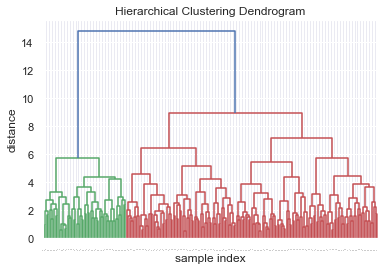

In [133]:
# Дендрограмма для МаксМин нормализации
#linkage - массив вычислений (в 3ем столбце содержится расстоянние между кластерами)

link_norm = linkage(df_for_clust_norm, 'ward', 'euclidean')
#plt.figure(figsize=(10, 6))
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('sample index')
plt.ylabel('distance')
dn_norm = dendrogram(link_norm, orientation = "top", leaf_font_size = 0)

#Метод Врда - сначала в обоих кластерах для всех имеющихся
#наблюдений производится расчёт средних значений отдельных переменных.
#Затем вычисляются квадраты евклидовых расстояний от отдельных наблюдений
#каждого кластера до этого кластерного среднего значения. Эти дистанции
#суммируются. Потом в один новый кластер объединяются те кластеры, которые
#дают наименьший прирост общей суммы дистанций.


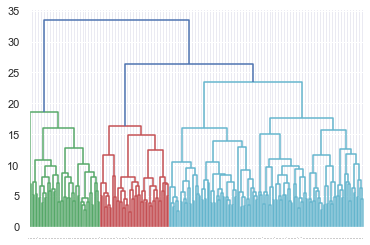

In [134]:
# Дендрограмма для z-нормализации
# Кажется, что z-нормализация дает более хороший результат (расстояния между кластерами выходят больше)
# По обоим дедрограммам выходит 3-4 кластеров.
# В дальнейшем будем работать с z-нормализацией.

link_znorm = linkage(df_for_clust_znorm, 'ward', 'euclidean')
dn_znorm = dendrogram(link_znorm, orientation = "top", leaf_font_size = 0)

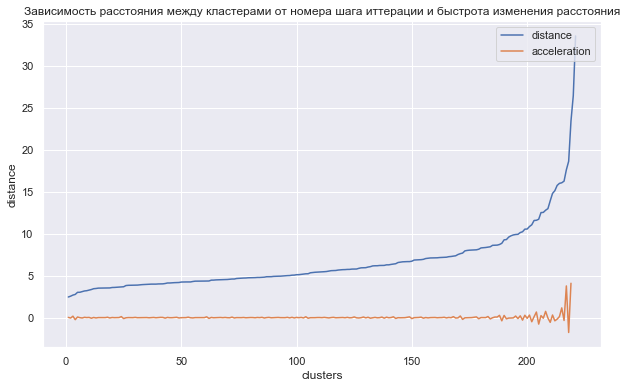

In [135]:
#На графике показана зависимость расстояния между кластерами 
#от номера шага итерации, на котором два ближайших кластера объединяются в новый. 
#Оранжевая линия показывает, как меняется ускорение - быстрота изменения расстояния между объединяемыми кластерами.

last = link_znorm[-300::, 2]
last_rev = last[::1]
idxs = np.arange(1, len(last) + 1)
plt.figure(figsize=(10, 6))
plt.plot(idxs, last_rev, label = 'distance')
acceleration = np.diff(last, 2) 
acceleration_rev = acceleration[::1]
plt.plot(idxs[:-2], acceleration_rev, label='acceleration')

plt.title('Зависимость расстояния между кластерами от номера шага иттерации и быстрота изменения расстояния')
plt.xlabel('clusters')
plt.ylabel('distance')
plt.legend(loc='upper right')


In [136]:
#Добавим к данным колонку cluster.
#Для этого используем функцию fcluster.
#Аргументы:
#1. linkage
#2. пороговое значение для расстояния между кластерами либо кол-во кластеров в зависимости от criterion
#3. maxclust для разбиения по заданному числу кластеров)

In [137]:
df_for_clust['cluster'] = fcluster(link_znorm, 4, criterion = 'maxclust')

In [138]:
means = df_for_clust.groupby('cluster').mean()
means_t = means.T
means_t

# Для изменяющихся показателей значения можно расшифровывать так:
# если значение > 1, то в кластере П в целом имеют значения признака выше средего 

cluster,1,2,3,4
Пол (1-Ж),0.851064,0.695652,0.779661,0.728571
Возраст (разбивка),2.297872,1.782609,2.288136,1.585714
Страна (1-RU),0.787234,0.847826,0.762712,0.828571
log(кол-во П в городе),1.297886,1.616259,0.845181,1.665026
"Категория (0,1,2,3)",1.382979,1.826087,1.016949,1.471429
Стаж работы П в целом (лет),7.489706,4.916030,10.466187,5.027662
ОГЭ,0.000000,0.956522,0.915254,0.871429
ЕГЭ,0.000000,0.586957,0.593220,0.514286
ВПР,0.510638,0.782609,0.203390,0.557143
Math Low knowledge,0.744681,0.847826,0.576271,0.714286


In [139]:
#1ый кластер:
#в оснвном женщины, возраст выше средего;
#не преподают егэ/огэ, в основном преподают в младших классах;
#готовят к олимпиадам;
#категория в среднем между B и С (больше В);
#процент переподбора ниже среднего.

#2ой кластер:
#нет выделяющегосы пола П, возраст ниже среднего;
#препеодают огэ/впр, в сновном П средних и старших классов;
#категория в среднем между B и С (больше С)
#процент переподбора средний;
#кол-во учеников и уроков в месяц выше среднего;

#3ий кластер:
#в оснвном женщины, возраст выше средего;
#препеодают огэ/егэ, в сновном П средних и старших классов;
#мало готовят к олимпиадам;
#категория в основном B,
#высокий стаж работы в целом (10 лет)
#маленький процент переподбора;
#кол-во учеников и уроков ниже среднего

#4ый кластер
#в оснвном женщины, возраст молодой;
#П средних и страших классов;
#высокий процент переподбора;
#ассесмент ниже среднего


In [140]:
df_for_clust.groupby('cluster').size()

cluster
1    47
2    46
3    59
4    70
dtype: int64